# Token Classification: customisation of NER tagging model for recognition of new entity using *spaCy*


## OBJECTIVE: recognise and tag all diseases from medical records / scientific literature in Spanish language

### Task 1: Make model to recognise all named entities in Spanish including diseases

###  Task 2: Read the text from all tweets in "*/training*" directory, tokenize it and label the tokens with IOB ner_tags *(for Spanish disease names only, ignoring other entities)*


### Datasets: 
1. *'Listado_enfermedades_CIE-10.csv'* : Disease list from CIE-10 (IDC-10, International Classification of Diseases 10th Revision, Spanish version https://icdcode.info/espanol/cie-10/codigos.html). This CSV list forked from https://github.com/verasativa/CIE-10 .
2. *'enfermedades_tweets.txt'* : List of "common names" of diseases in Spanish obtained by scraping from tweets *(private, not uploaded to GitHub)*
3. *'/training/ * .txt'*: Collection of 5.000 Spanish tweets mentioning diseases and pathologies, one tweet per TXT file *(private, not uploaded to GitHub)*

In [1]:
# Importing basic libraries
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Installation of spaCy models for Spanish (https://spacy.io/models/es)

# !python -m spacy download es_core_news_sm    # Small model

# !python -m spacy download es_core_news_md    # Medium-size model

# !python -m spacy download es_core_news_lg    # Long model

# !python -m spacy download es_dep_news_trf    # Transformer pipeline (dccuchile/bert-base-spanish-wwm-cased)

In [4]:
import random

In [5]:
import re

In [6]:
from pathlib import Path

In [7]:
training_dir = Path('Input/training')

### Load input examples and disease database

**Challenges**:
1. Uppercase/Lowercase
2. Unicode characters (e.g.: 'á', 'é', 'í', 'ü', 'â', 'ñ' might be written different way)
3. Multiple entries of the same disease (*'covid'/'covid-19'/'covid 19'*;  *'diabetis'/'diabet'/'diabética'*) 

**Normalization** and **Curation** might be necessary for some approaches:
1. Normalization for disease list and for every input text (tweet) before analysis.
2. For DL approach: train model for all possible spelling variants

In [8]:
# Input standartization (Uppercase/lowercase, unicode chars)

import unicodedata
def normalize_caseless(text):
    return unicodedata.normalize("NFKD", text.casefold())

In [9]:
# Reading of list from file (one disease name per line)
#'Common names" for diseases obtained from tweets

with open('Input/enfermedades_tweets.txt') as file:
    diseases_from_tweets= re.split(r'[\n#@%:;¡!?¿/]', normalize_caseless(file.read()))   

In [10]:
random.sample(diseases_from_tweets, 20)

['cáncerdemama',
 'rotura ligamento cruzado interior',
 'síndrome de ovario poliquístico',
 'phelan',
 'síndrome de abstinencia',
 'tentativa de suicidio',
 'estenosis',
 'alergia al limón',
 'bloqueo 💔grado 1 o 2',
 'pelvis renal bífida',
 'hemorragia intraventricular, afectación infrantentorial',
 'víctima de maltrato',
 'neurofibromatosis tipo ii',
 'cuadro gripal',
 'hipotensión grave',
 'les en adultos',
 'pápulas excoriadas y algunas vesículas en codos, región lumbar y glúteos',
 'cicatrices en el corazón',
 'jaquecas',
 'acv en ganglios basales']

In [11]:
len(diseases_from_tweets)

4357

In [12]:
# Reading of "official" disease names (according to IDC-10 / CIE-10 standard) from CSV file

cie = pd.read_csv('Input/Listado_enfermedades_CIE-10.csv')
cie.head()

,code,code_0,code_1,code_2,code_3,code_4,description,level,source
0,A00-B99,NaN,NaN,NaN,NaN,NaN,Ciertas enfermedades infecciosas y parasitarias,0,icdcode.info
1,C00-D49,NaN,NaN,NaN,NaN,NaN,Tumores [neoplasias],0,icdcode.info
2,D50-D89,NaN,NaN,NaN,NaN,NaN,Enfermedades de la sangre y de los órganos hem...,0,icdcode.info
3,E00-E89,NaN,NaN,NaN,NaN,NaN,"Enfermedades endocrinas, nutricionales y metab...",0,icdcode.info
4,F01-F99,NaN,NaN,NaN,NaN,NaN,Trastornos mentales y del comportamiento,0,icdcode.info


In [13]:
cie[200:220]

,code,code_0,code_1,code_2,code_3,code_4,description,level,source
200,H05,H00-H59,H00-H06,NaN,NaN,NaN,Trastornos de la órbita,2,icdcode.info
201,H06,H00-H59,H00-H06,NaN,NaN,NaN,Trastornos del aparato lagrimal y de la órbita...,2,icdcode.info
202,P75-P78,P00-P96,NaN,NaN,NaN,NaN,Trastornos del sistema digestivo del feto y de...,1,icdcode.info
203,P80-P83,P00-P96,NaN,NaN,NaN,NaN,Afecciones asociadas con la regulación tegumen...,1,icdcode.info
204,P90-P96,P00-P96,NaN,NaN,NaN,NaN,Otros trastornos originados en el período peri...,1,icdcode.info
205,O60-O75,O00-O9A,NaN,NaN,NaN,NaN,Complicaciones del trabajo de parto y del parto,1,icdcode.info
206,O80-O84,O00-O9A,NaN,NaN,NaN,NaN,Parto,1,icdcode.info
207,O85-O92,O00-O9A,NaN,NaN,NaN,NaN,Complicaciones principalmente relacionadas con...,1,icdcode.info
208,O94-O99,O00-O9A,NaN,NaN,NaN,NaN,Otras afecciones obstétricas no clasificadas e...,1,icdcode.info
209,F40,F01-F99,F40-F48,NaN,NaN,NaN,Trastornos fóbicos de ansiedad,2,icdcode.info


In [14]:
# Removing Disease Codes from disease description
cie_list1 = [re.sub(r' \([A-Z]\d\d.*', '', disease) for disease in cie.description.to_list()]

In [15]:
# Generalisation of disease names (e.g., "Other anxiety disorders -> "anxiety disorders")
cie_list2 = [re.sub(r'^Otr[oa]s ', '', disease) for disease in cie_list1]

In [16]:
# Normalization of disease name
cie_list3 = [normalize_caseless(disease) for disease in cie_list2] 

In [17]:
len(cie_list3)

14498

In [18]:
# Prepare final list: merge two original lists,  remove possible duplicates and sort in alphabetical order
diseases = sorted(set(diseases_from_tweets + cie_list3))

In [19]:
diseases.remove('')

In [20]:
len(diseases)

18417

In [21]:
random.sample(diseases, 20)

['corrosión del tronco, de segundo grado',
 'ocupante de automovil lesionado por colision con objeto fijo o estacionado: conductor lesionado en accidente no de transito',
 'ocupante de camioneta o furgoneta lesionado por colision con peaton o animal: ocupante no especificado de camioneta o furgoneta, lesionado en accidente de transito',
 'intento suicida',
 'exposición a fuerzas mecánicas animadas',
 'trastornos no especificados del oído y de la apófisis mastoides, consecutivos a procedimientos',
 'ocupante de vehiculo de transporte pesado lesionado por colision con otros vehiculos sin motor: persona lesionada al subir o bajar del vehiculo',
 'parálisis cerebral mixta',
 'lunares',
 'síndrome de dolor regional complejo',
 'hipospadias perineal',
 'trastornos de la refracción',
 'autistas sin discapacidad intelectual',
 'afonía',
 'malformaciones congénitas de la córnea',
 'envenenamiento accidental por, y exposicion a otros productos quimicos y sustancias nocivas, y los no e

In [22]:
# Save disease name as TXT file (one disease name per line)
with open('Output/enfermedades.txt', 'w') as file:
    for item in diseases:
        file.write(f'{item}\n')

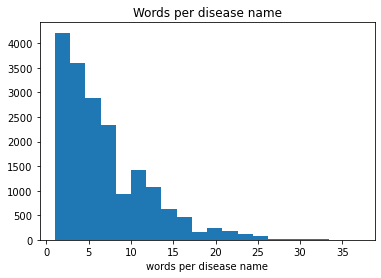

In [23]:
# Plot number of words in disease names

plt.hist([len(disease.split()) for disease in diseases], bins=20)
plt.title('Words per disease name')
plt.xlabel('words per disease name')
plt.show()

In [24]:
# The longest disease name
max(diseases, key=len)

'envenenamiento autoinfligido intencionalmente por, y exposicion a drogas antiepilepticas, sedantes, hipnoticas, antiparkinsonianas y psicotropicas, no clasificadas en otra parte: escuelas, otras instituciones y areas administrativas publicas'

### NER tags annotation

In [25]:
# Create pattern dictionary for model training

patterns = [{'label': 'DISEASE', 'pattern': item} for item in diseases]

In [26]:
patterns[:5]

[{'label': 'DISEASE', 'pattern': 'abcesos intrabdominales'},
 {'label': 'DISEASE', 'pattern': 'abdomen agudo'},
 {'label': 'DISEASE', 'pattern': 'abertura artificial, no especificada'},
 {'label': 'DISEASE', 'pattern': 'aberturas artificiales'},
 {'label': 'DISEASE', 'pattern': 'abortadora habitual'}]

In [27]:
import spacy
nlp = spacy.load("es_core_news_sm") # load NLP model for Spanish

In [28]:
# Create new blank model using EntityRuler

from spacy.lang.es import Spanish
custom_nlp = Spanish()
ruler = custom_nlp.add_pipe("entity_ruler")
ruler.add_patterns(patterns)
ruler.to_disk('disease-ruler')

In [29]:
ruler

In [30]:
# Load saved custom NER model and add it as new pipe to standard model
loaded_ruler = spacy.load('disease-ruler', vocab=nlp.vocab)
nlp.add_pipe("entity_ruler", source=loaded_ruler, before="ner")

/home/drphyl/anaconda3/lib/python3.9/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'es_pipeline' (0.0.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.4.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [31]:
nlp.pipe_names

['tok2vec',
 'morphologizer',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'entity_ruler',
 'ner']

In [32]:
# Examples of input and desired output for testing

input_examples = [
    [
        'Estoy enferma y dejaron de pagarme mi sueldo bien ahi sindicato de comercio #carlosperez #endometriosis #fibromialgia #artritis #soycomercio\n\n\n',
        ['Estoy', 'enferma', 'y', 'dejaron', 'de', 'pagarme', 'mi', 'sueldo', 'bien', 'ahi', 'sindicato', 'de', 'comercio', '#', 'carlosperez', '#', 'endometriosis', '#', 'fibromialgia', '#', 'artritis', '#', 'soycomercio', '\n\n\n'],
        ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'B', 'O', 'B', 'O', 'O', 'O']
    ],
   
    
    [
        '¿Qué probabilidad hay de no pillar la gripe si me paso la vida en el hospital?\n\n\n\n\n\n',
        ['¿', 'Qué', 'probabilidad', 'hay', 'de', 'no', 'pillar', 'la', 'gripe', 'si', 'me', 'paso', 'la', 'vida', 'en', 'el', 'hospital', '?', '\n\n\n\n\n\n'],
        ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
    ],

    
    [
         'Empezamos a emparejar el marcador covid-19 https://t.co/dGEUtRuxAo\n\n\n\n\n\n',
         ['Empezamos', 'a', 'emparejar', 'el', 'marcador', 'covid-19', 'https://t.co/dGEUtRuxAo', '\n\n\n\n\n\n'],
         ['O', 'O', 'O', 'O', 'O', 'B', 'O', 'O']
    ],
         
       
    [
        'y me dio un ataque de ansiedad\n\n\n\n\n\n',
        ['y', 'me', 'dio', 'un', 'ataque', 'de', 'ansiedad', '\n\n\n\n\n\n'],
        ['O', 'O', 'O', 'O', 'B', 'I', 'I', 'O']
    ]
]

In [33]:
# Function to get Tokens and corresponding IOB annotations for Diseases ( (ignoring all other entities except DISEASES)

def tokens_IOB_tag(text):
    doc = nlp(text, disable='ner')       # use CUSTOM 'entity_ruler' model instead of original 'ner'
    tokens = [ent.text for ent in doc] 
    ner_tags = [ent.ent_iob_ for ent in doc]
    return tokens, ner_tags

In [34]:
# Function to recognise all entities (both standard and custom)

def NER(text):
    doc = nlp(text)
    for entity in doc.ents:
        print(entity.text, entity.label_)

In [35]:
text = "¿Qué probabilidad hay de no pillar la gripe si me paso la vida en el hospital ?\n\n\n\n\n"

In [36]:
NER(text)

gripe DISEASE
hospital ? LOC


In [37]:
for example in input_examples:
    NER(example[0])
    print('===')

endometriosis DISEASE
fibromialgia DISEASE
artritis DISEASE
===
gripe DISEASE
===
covid-19 DISEASE
===
ataque de ansiedad DISEASE
===


In [38]:
for example in input_examples:
    tokens, ner_tags = tokens_IOB_tag(example[0])
    print(tokens, '\n', ner_tags, '\n\n')

['Estoy', 'enferma', 'y', 'dejaron', 'de', 'pagarme', 'mi', 'sueldo', 'bien', 'ahi', 'sindicato', 'de', 'comercio', '#', 'carlosperez', '#', 'endometriosis', '#', 'fibromialgia', '#', 'artritis', '#', 'soycomercio', '\n\n\n'] 
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'B', 'O', 'B', 'O', 'O', 'O'] 


['¿', 'Qué', 'probabilidad', 'hay', 'de', 'no', 'pillar', 'la', 'gripe', 'si', 'me', 'paso', 'la', 'vida', 'en', 'el', 'hospital', '?', '\n\n\n\n\n\n'] 
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] 


['Empezamos', 'a', 'emparejar', 'el', 'marcador', 'covid-19', 'https://t.co/dGEUtRuxAo', '\n\n\n\n\n\n'] 
 ['O', 'O', 'O', 'O', 'O', 'B', 'O', 'O'] 


['y', 'me', 'dio', 'un', 'ataque', 'de', 'ansiedad', '\n\n\n\n\n\n'] 
 ['O', 'O', 'O', 'O', 'B', 'I', 'I', 'O'] 




In [39]:
# Test for tokens_IOB_tag()

for i, example in enumerate(input_examples):
    print(f'* Example {i+1} *')
    tokens, ner_tags = tokens_IOB_tag(example[0])
    if tokens == example[1]:
        print('Tokens CORRECT')
    else:
        print('Tokens WRONG')
        print(f'Calculated: {tokens}\nOriginal:   {example[1]}\n')
        
    if ner_tags == example[2]:
        print('NER tags CORRECT\n\n')
    else:
        print('NER tags WRONG')
        print(f'Calculated: {ner_tags}\nOriginal:   {example[2]}\n\n')

* Example 1 *
Tokens CORRECT
NER tags CORRECT


* Example 2 *
Tokens CORRECT
NER tags CORRECT


* Example 3 *
Tokens CORRECT
NER tags CORRECT


* Example 4 *
Tokens CORRECT
NER tags CORRECT




## Create annotated dataset from tweet files

In [40]:
filelist = [file for file in Path(training_dir).iterdir() if file.glob('*.txt')]
len(filelist)

5000

In [41]:
# Preparation of output dataset with two columns:
# tokens: array of tokens of the tweet; 
# ner_tags: array of tag annotations (I, O, B).

tokens_tags_list = []
tweet_len = []
for file in filelist:
    tweet = file.read_text(encoding="UTF-8")
    tokens_tags_list.append(tokens_IOB_tag(tweet))
    tweet_len.append(len(tweet))

In [42]:
max(tweet_len)

331

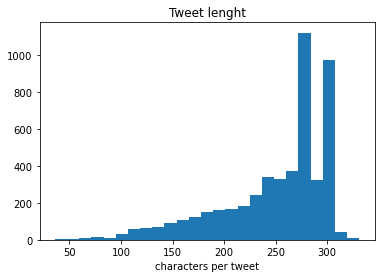

In [43]:
# Plot Lenght of tweets

plt.hist(tweet_len, bins=25)
plt.title('Tweet lenght')
plt.xlabel('characters per tweet')
plt.show()

In [44]:
annotated_df = pd.DataFrame(tokens_tags_list, columns = ['tokens', 'ner_tags'])
annotated_df

,tokens,ner_tags
0,"[CON, LO, CUAL, PARA, CUANDO, LES, DAN, POR, C...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[AUTISMO, +, COVID, 19, \n, INSAR, ha, puesto,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[La, muerte, por, asfixia, por, atragantamient...","[O, B, O, B, I, I, O, O, O, O, O, O, O, O, O, ..."
3,"[y, ,, hago, spoiler, ,, desgraciadamente, seg...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[El, calor, me, da, ansiedad, ,, cuando, digo,...","[O, O, O, O, B, O, O, O, B, O, O, B, O, O]"
...,...,...
4995,"[Si, tienes, síntomas, d, gripe, descansa, ,, ...","[O, O, O, O, B, O, O, O, O, O, O, O, O, O, O, ..."
4996,"[💜, ¡, Feliz, Día, Internacional, de, la, Muje...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4997,"[Mi, hermano, padece, una, enfermedad, neuroló...","[O, O, O, O, B, O, O, O, O, O, B, O, O, O, O, ..."
4998,"[Hace, 17, años, mi, vida, cambió, ..., \n, Y,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [45]:
print(annotated_df.iloc[15][0])

['Una', 'niña', 'víctima', 'de', 'maltrato', 'de', 'quienes', 'están', 'llamados', 'a', 'cuidarla', '.', 'La', 'muerte', 'fue', 'el', 'fin', 'al', 'dolor', ',', 'pero', 'se', 'fue', 'sin', 'tener', 'respuesta', 'a', 'su', 'pregunta', '.', '\n', '¿', 'por', 'qué', 'mamá', 'no', 'me', 'quiere', '?', '💔', '\n', '@justiciaPPaula', ' ', '#', 'JusticiaParaPaula', 'https://t.co/cE95Q6uV08', '\n\n\n\n\n\n']


In [46]:
# Saving of token list and Ner_tags to CSV file
annotated_df.to_csv('Output/annotated_diseases.tsv', index=None,  encoding='UTF-8', sep='\t')